# Importing libraries and creating basic functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import pandas as pd

In [109]:
@numba.njit
def get_sim_noise(trials=1000, stimulus=1, noise_sd=1, start_stim = 1, end_stim = 4, tmax = 5, dt = 0.01):
    noise = np.zeros(shape = (trials, int(tmax/dt)))
    
    if stimulus == 1:
        start = int(start_stim / dt)
        end = int(end_stim / dt)
        noise[:, start:end] = 1
    
    noise *= dt
    
    for i in range(1, int(tmax/dt)):
        noise[:, i] += np.random.normal(0, noise_sd, trials)*np.sqrt(dt)    
    
    return noise

@numba.njit
def get_DDM_traces(v, z=0.5, a=1, dc=0, dc_slope=0, sv=0.1, noise_sd=1, nr_trials=1000, tmax=5.0, dt=0.01):
    
    """
    DDM

    v:  mean drift rate
    z:  starting point
    dc: drift criterion
    """
    x = np.zeros((nr_trials, int(tmax/dt)))
    x[:,:] = np.NaN
    x[:,0] = z*a
    for i in range(1, int(tmax/dt)):
        x[:,i] = x[:,i-1] + v[:, i] + dc*dt
    return x

@numba.njit
def _bounds(a=1, lower_is_0=True, tmax=5, dt=0.01):
    t = np.arange(0, tmax, dt)
    b1 = np.ones(len(t)) * a
    if lower_is_0:
        b0 = np.zeros(len(t))
    else:
        b0 = -b1
    return b0, b1

@numba.njit
def apply_bounds_diff_trace(x, b1, dt=0.01):
    
    end_time = int(x.shape[1])
    
    rt = np.zeros(x.shape[0]) + end_time #FIX THIS LATER
    print(rt)
    response = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i,j] >= b1[j]:
                rt[i] = j
                response[i] = 1
                break

    rt *= dt
    return rt, response

def get_df(response, rt, start_stim, end_stim, tmax=5, dt=0.01):
    
    df = pd.DataFrame()
    df['rt'] = rt
    df['response'] = response
    df['false alarm'] = df['rt'] < start_stim
    df['miss'] = df["rt"] == tmax
    df['hit'] = ~df['false alarm'] & ~df['miss']
    return df



# function that does the whole simulation and returns df

In [110]:
def do_sim():
    start_stim = 2
    end_stim =5
    tmax = 5
    dt = 0.01
    a = 1
    trials = 10000
    
    v = get_sim_noise(stimulus=1, noise_sd = 1, start_stim=start_stim, end_stim = end_stim, trials=trials)
    x = get_DDM_traces(v, nr_trials = trials)
    
    b1=np.ones(int(tmax/dt)) * a
    
    rt, response = apply_bounds_diff_trace(x, b1)
    df = get_df(response, rt, start_stim, end_stim)
    return v, df
    

In [112]:
start_stim = 2
end_stim =5
tmax = 5
dt = 0.01
a = 1
trials = 10000

v = get_sim_noise(stimulus=1, noise_sd = 1, start_stim=start_stim, end_stim = end_stim, trials=trials)
x = get_DDM_traces(v, nr_trials = trials)

b1=np.ones(int(tmax/dt)) * a

rt, response = apply_bounds_diff_trace(x, b1)
df = get_df(response, rt, start_stim, end_stim)

[500. 500. 500. ... 500. 500. 500.]


In [114]:
df.head()
df.mean()

rt             1.442443
response       0.944600
false alarm    0.694600
miss           0.055400
hit            0.250000
dtype: float64

C:\Users\Sarim Aleem\Miniconda3\envs\pupil\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


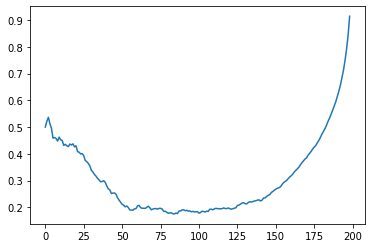

In [161]:
num_false_alarms = int(df.sum()['false alarm'])
faoffset = np.zeros(shape=(num_false_alarms, 200))
faoffset[:, :] = np.nan
dt = 0.01


fa_trace = x[df['false alarm']]
fa_rt = np.asarray(df[df['false alarm']]['rt'])
for i in range(num_false_alarms):
    rt_index = int(fa_rt[i] / dt)
    faoffset[i, 200-rt_index:] = fa_trace[i, 0:rt_index]
    
faoffsetmean = np.nanmean(faoffset, axis = 0)[~np.isnan(np.nanmean(faoffset, axis = 0))]
plt.plot(faoffsetmean)


In [180]:
def plot_faoffset(x, df):
    num_false_alarms = int(df.sum()['false alarm'])
    faoffset = np.zeros(shape=(num_false_alarms, 500))
    faoffset[:, :] = np.nan
    dt = 0.01
    
    fa_trace = x[df['false alarm']]
    fa_rt = np.asarray(df[df['false alarm']]['rt'])
    for i in range(num_false_alarms):
        rt_index = int(fa_rt[i] / dt) + 1
        faoffset[i, 500-rt_index:] = fa_trace[i, 0:rt_index]

    faoffsetmean = np.nanmean(faoffset, axis = 0)[~np.isnan(np.nanmean(faoffset, axis = 0))]
    plt.plot(faoffsetmean)
    plt.title('false alarm offset')
    
def plot_hit_offset(x, df):
    num_hits = int(df.sum()['hit'])
    hitoffset = np.zeros(shape=(num_hits, 500))
    hitoffset[:, :] = np.nan
    dt = 0.01
    
    hit_trace = x[df['hit']]
    hit_rt = np.asarray(df[df['hit']]['rt'])
    for i in range(num_hits):
        rt_index = int(hit_rt[i] / dt) + 1
        hitoffset[i, 500-rt_index:] = hit_trace[i, 0:rt_index]

    hitoffset = np.nanmean(hitoffset, axis = 0)[~np.isnan(np.nanmean(hitoffset, axis = 0))]
    plt.plot(hitoffset)
    plt.title('hit offset')
    
# def plot_miss_offset(x, df):
#     num_miss = int(df.sum()['miss'])
#     missoffset = np.zeros(shape=(num_miss, 500))
#     missoffset[:, :] = np.nan
#     dt = 0.01
    
#     #hello human being
    
#     miss_trace = x[df['miss']]
#     miss_rt = np.asarray(df[df['miss']]['rt'])
#     for i in range(num_miss):
#         rt_index = int(miss_rt[i] / dt) + 1
#         missoffset[i, 500-rt_index:500] = miss_trace[i, 0:rt_index]
        

#     missoffset = np.nanmean(missoffset, axis = 0)[~np.isnan(np.nanmean(missoffset, axis = 0))]
#     plt.plot(missoffset)
#     plt.title('miss offset')
    
def create_figs(df,x, v):
    
    avg_fa_trace = np.mean(x[df['false alarm']], axis=0)
    plt.plot(avg_fa_trace)
    plt.title('average false alarm trace')
    
    
    plt.figure()
    plot_faoffset(x, df)
    plt.figure()
    plot_hit_offset(x, df)
    plt.figure()
    plot_miss_offset(x, df)
    


    
    

    

C:\Users\Sarim Aleem\Miniconda3\envs\pupil\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


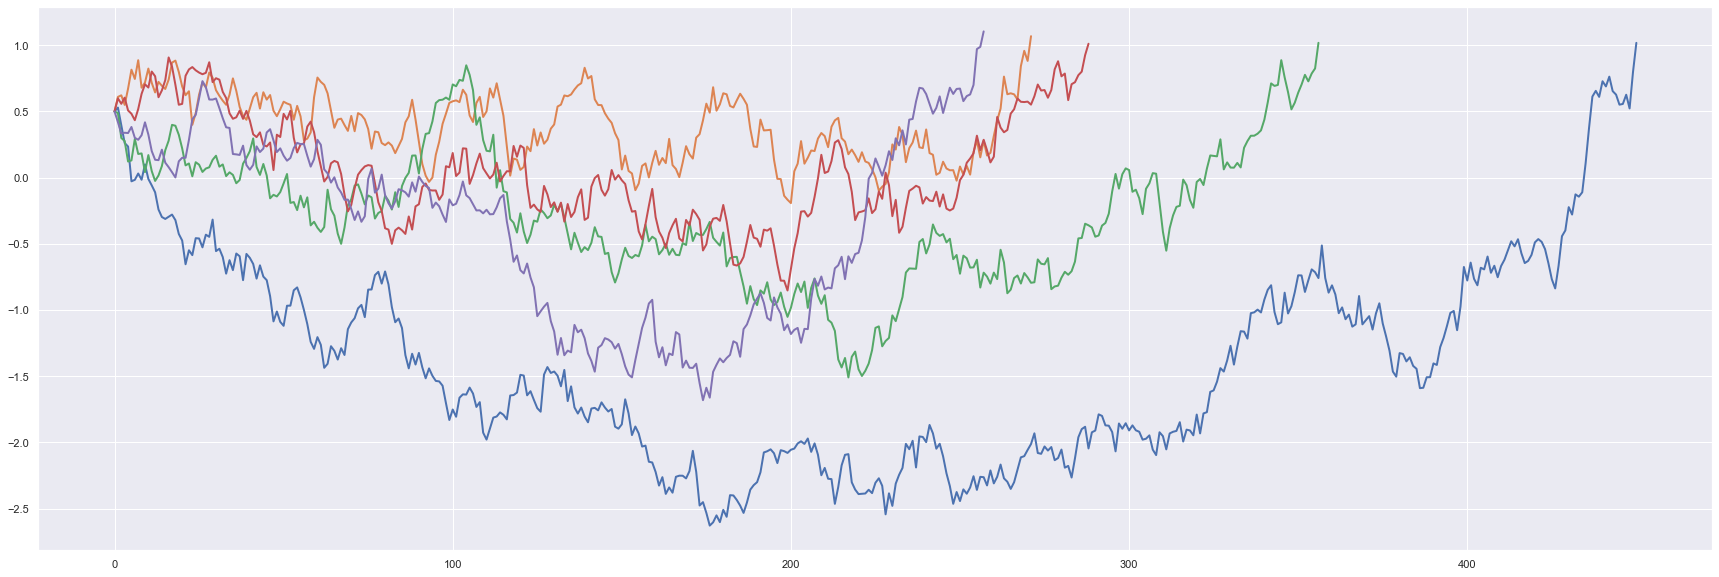

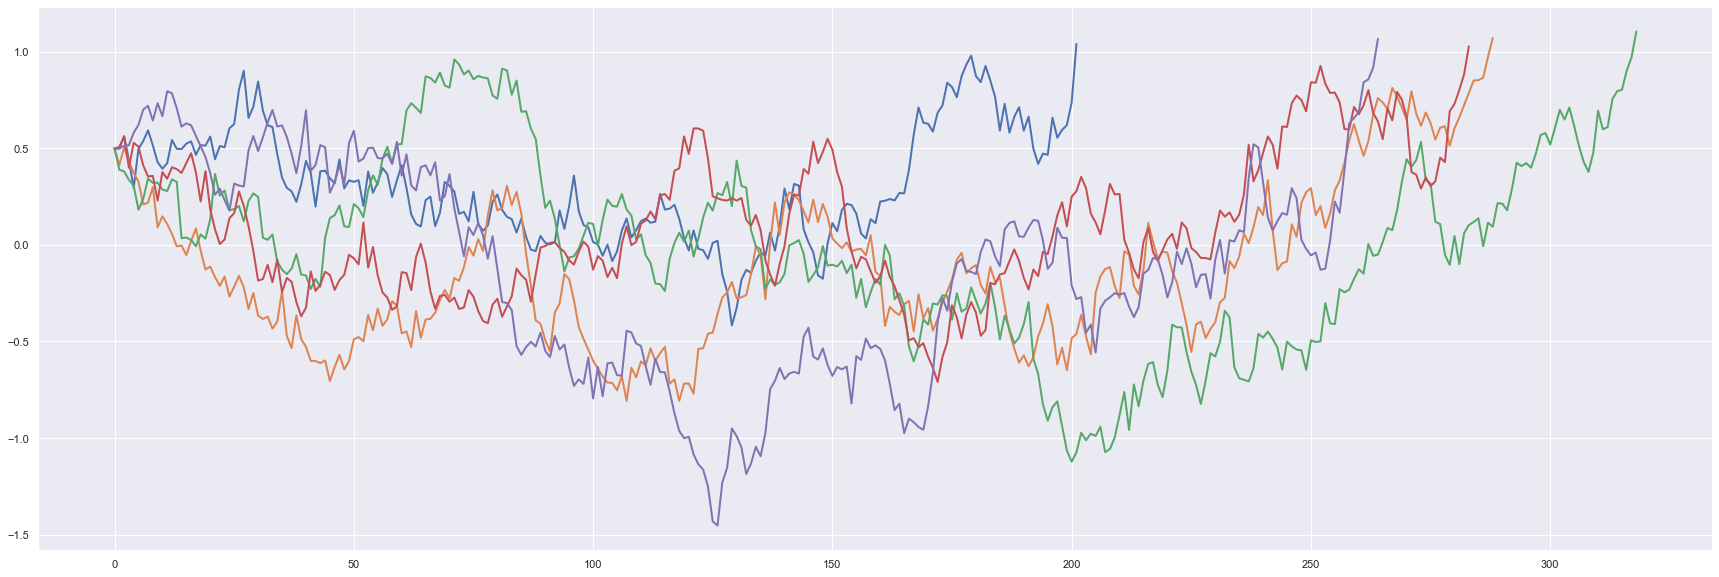

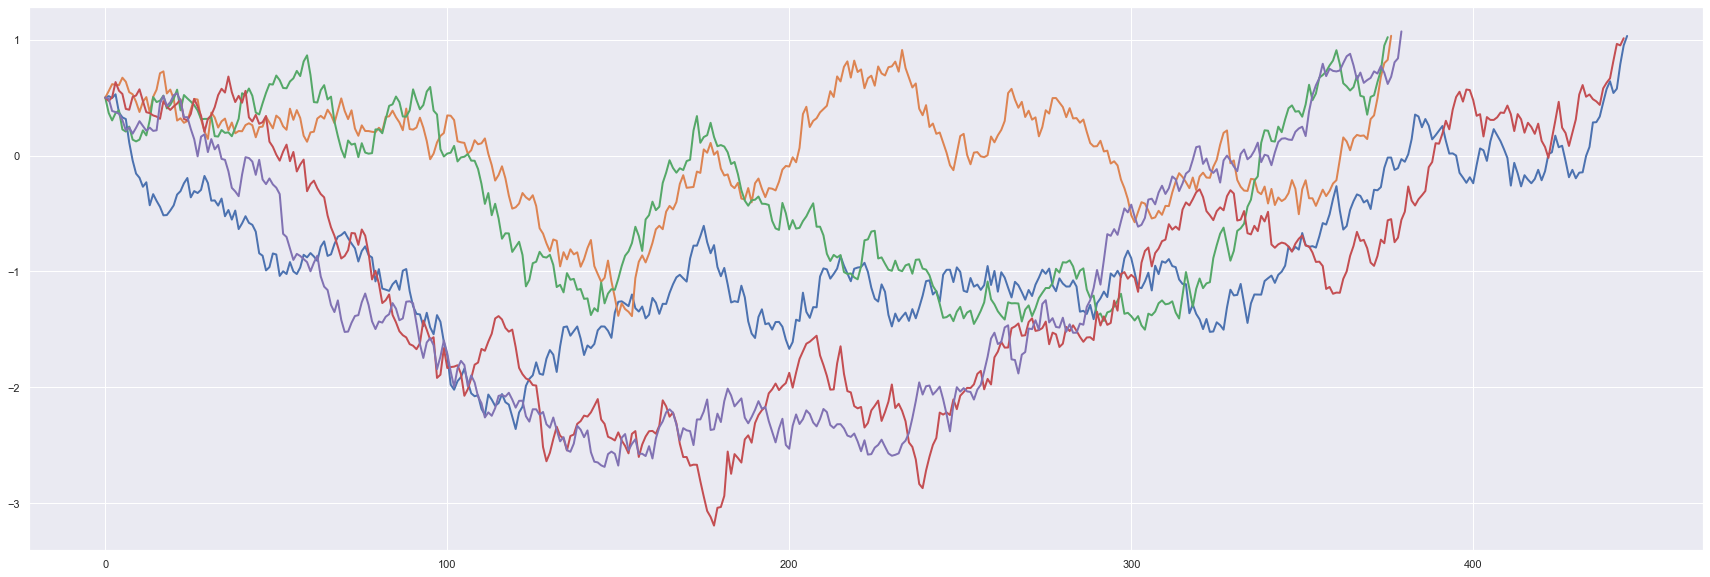

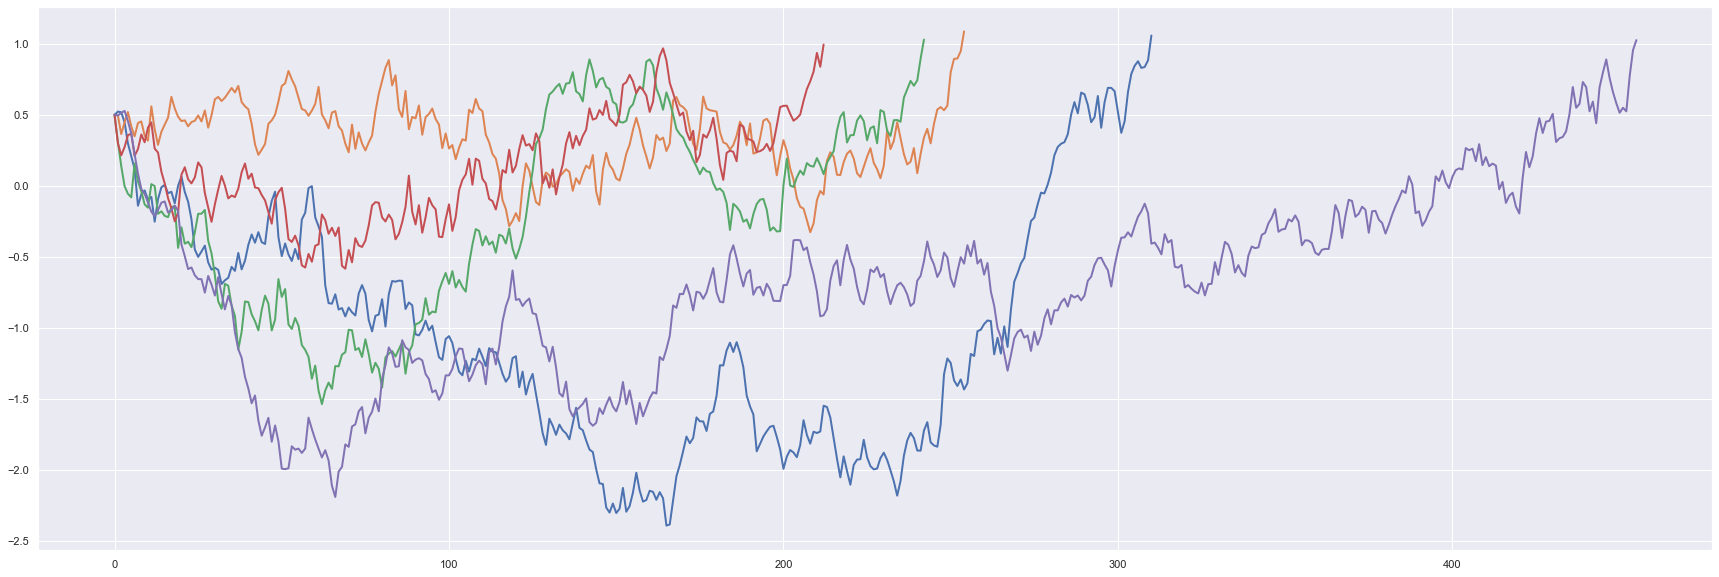

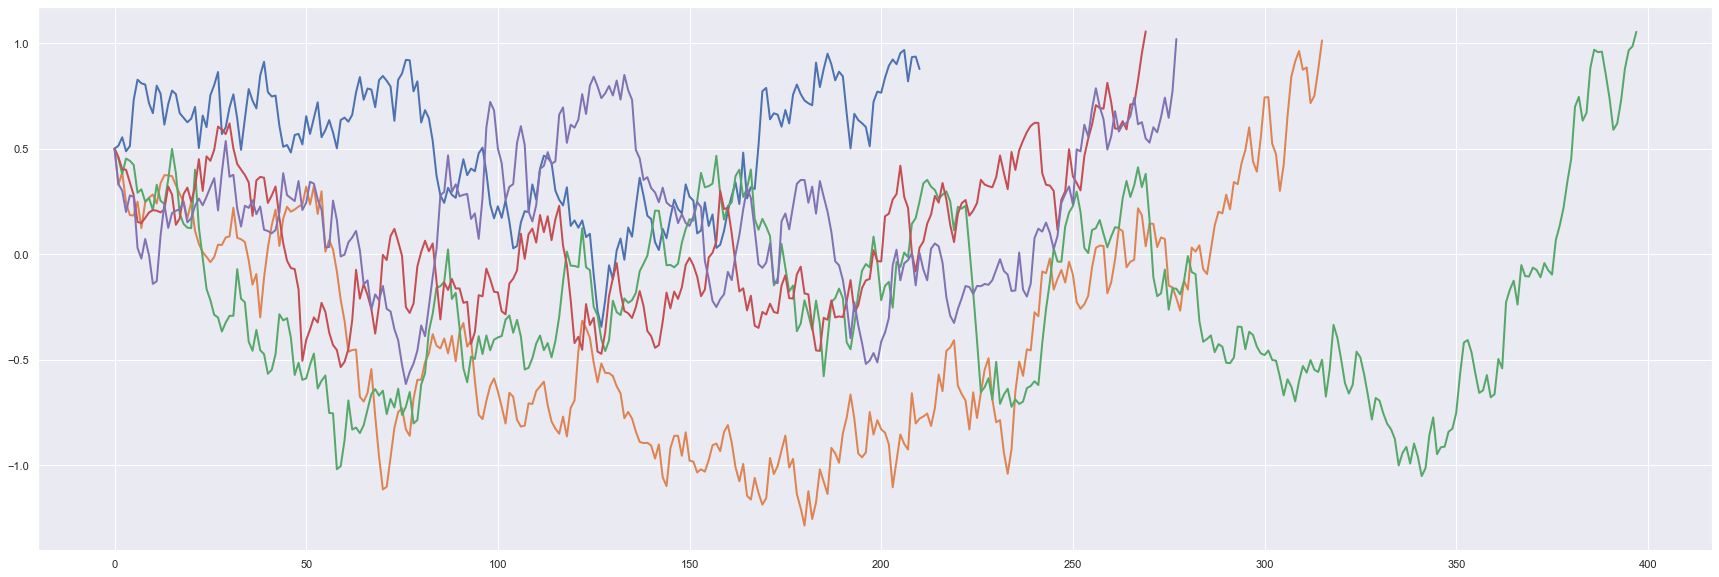

In [199]:
num_hits = int(df.sum()['hit'])
hitoffset = np.zeros(shape=(num_hits, 500))
hitoffset[:, :] = np.nan
dt = 0.01

sns.set()

hit_trace = x[df['hit']]
hit_rt = np.asarray(df[df['hit']]['rt'])
for i in range(25):
    rt_index = int(hit_rt[i] / dt) + 1
    hitoffset[i, 500-rt_index:] = hit_trace[i, 0:rt_index]
    trace = hit_trace[i, 0:rt_index]
#     plt.figure()
    if i % 5 == 0:
        plt.subplots(figsize=(30, 10))
    
    plt.plot(trace, linewidth =2)

hitoffset = np.nanmean(hitoffset, axis = 0)[~np.isnan(np.nanmean(hitoffset, axis = 0))]
#plt.plot(hitoffset)
#plt.title('hit offset')

C:\Users\Sarim Aleem\Miniconda3\envs\pupil\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


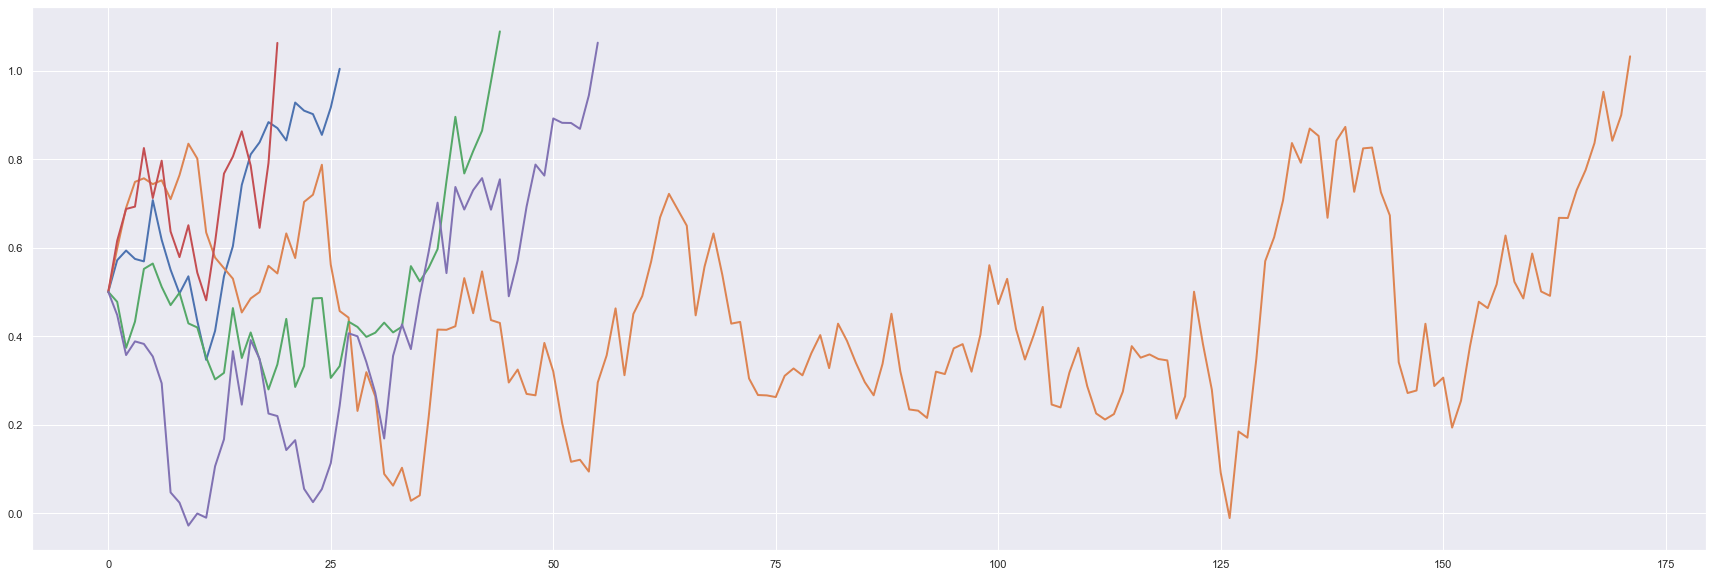

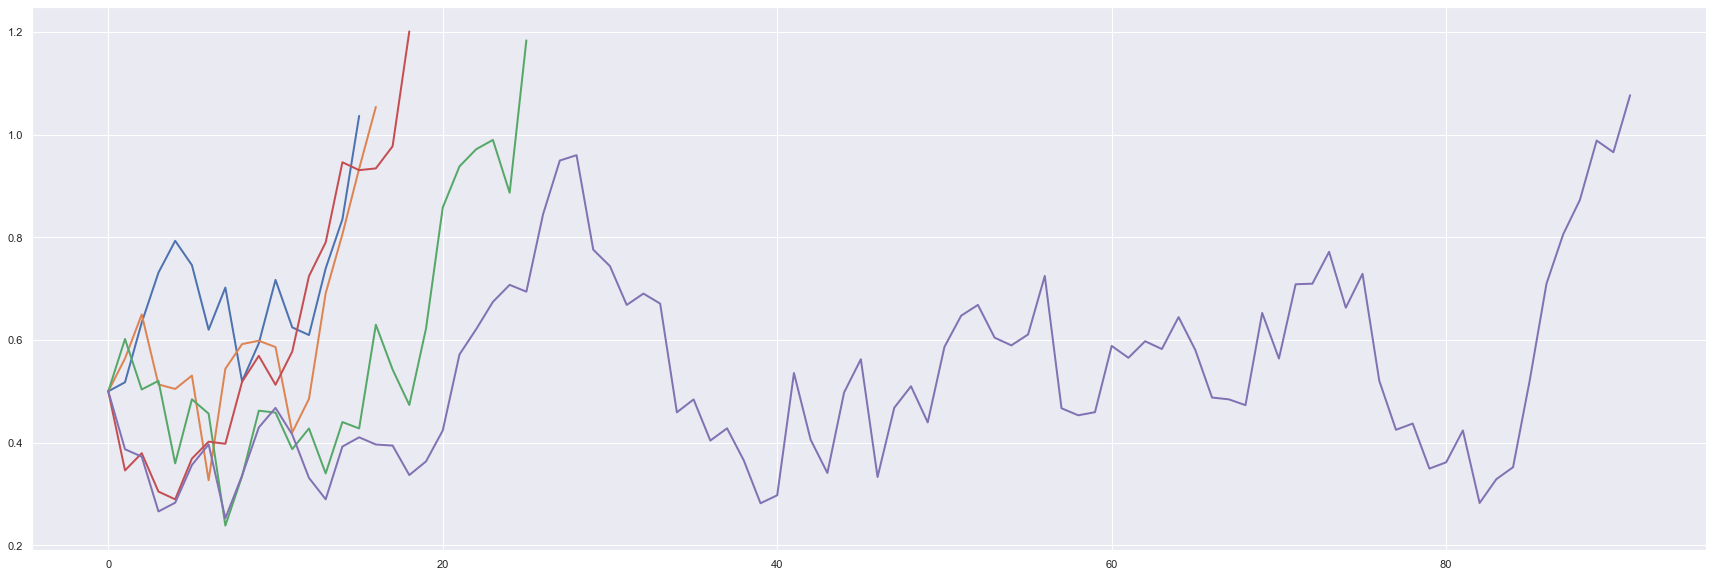

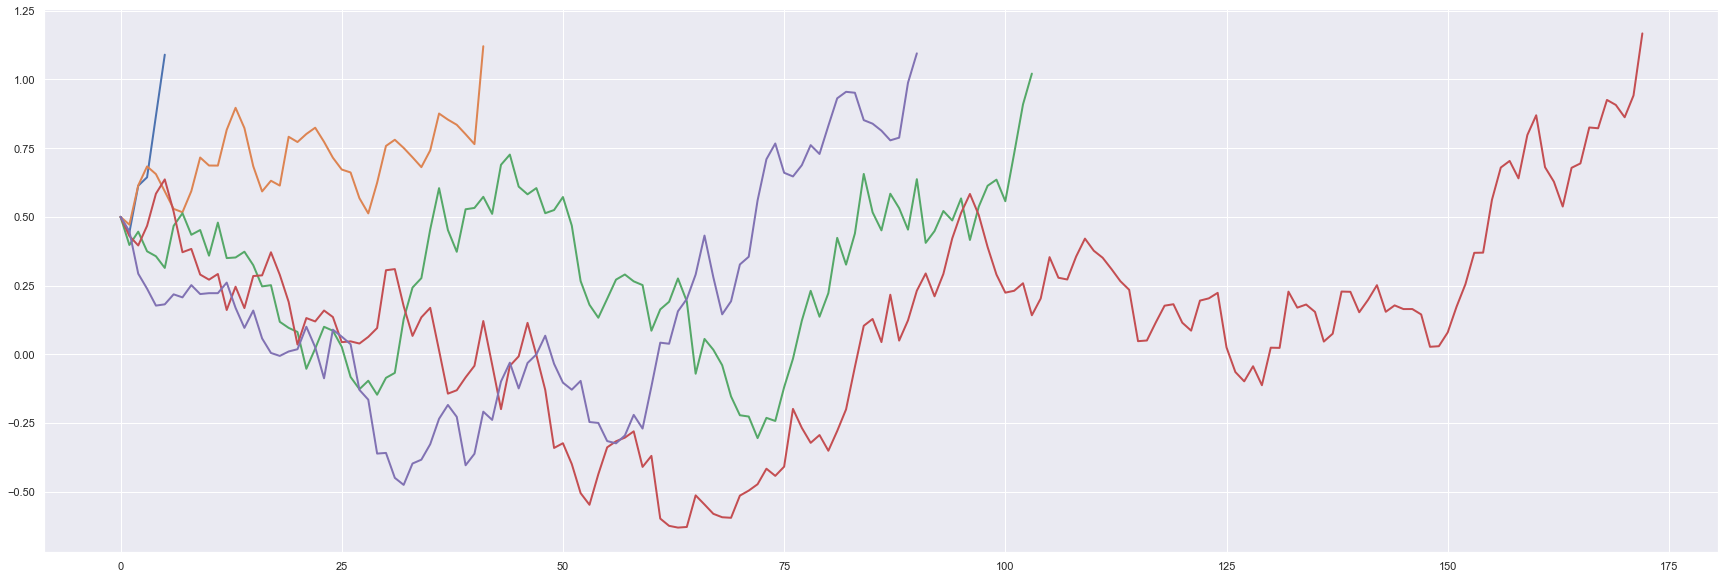

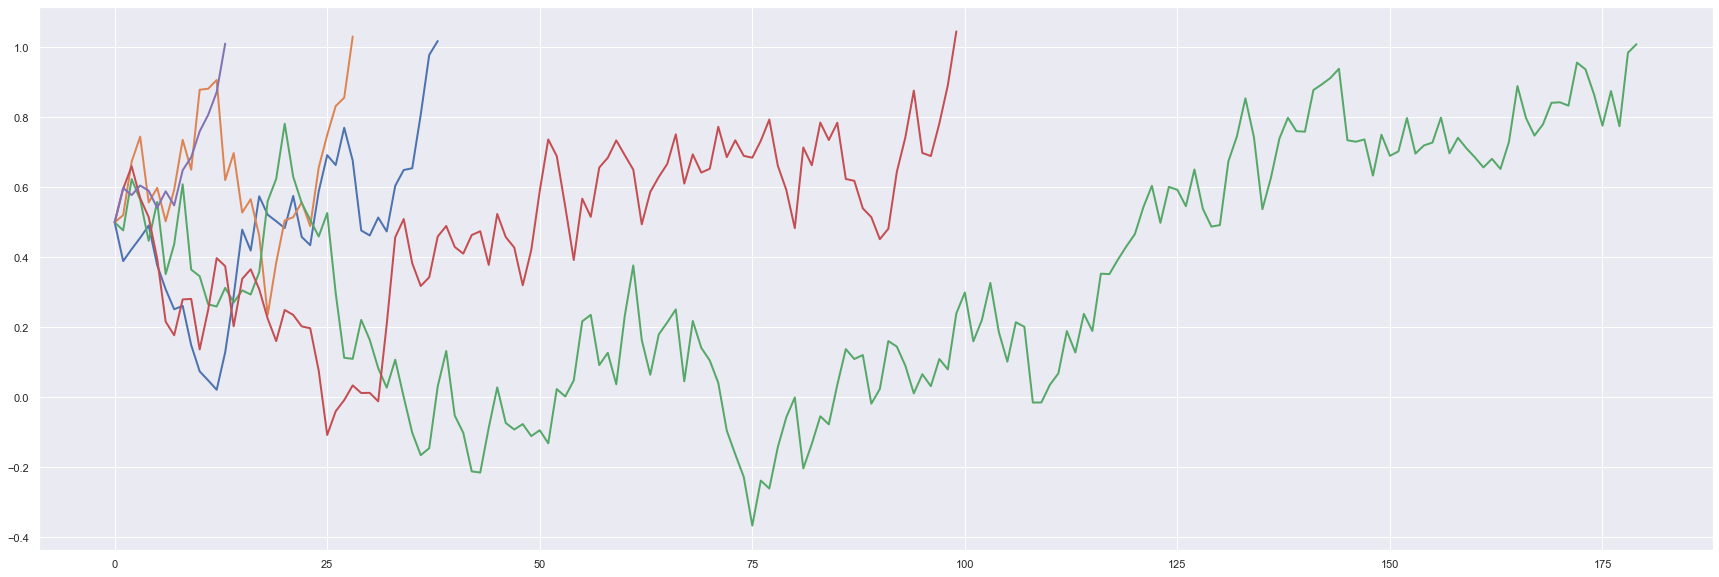

In [201]:
num_false_alarms = int(df.sum()['false alarm'])
faoffset = np.zeros(shape=(num_false_alarms, 500))
faoffset[:, :] = np.nan
dt = 0.01

fa_trace = x[df['false alarm']]
fa_rt = np.asarray(df[df['false alarm']]['rt'])
for i in range(20):
    rt_index = int(fa_rt[i] / dt) + 1
    faoffset[i, 500-rt_index:] = fa_trace[i, 0:rt_index]
    
    trace = fa_trace[i, 0:rt_index]
#     plt.figure()
    if i % 5 == 0:
        plt.subplots(figsize=(30, 10))
    
    plt.plot(trace, linewidth =2)
    

faoffsetmean = np.nanmean(faoffset, axis = 0)[~np.isnan(np.nanmean(faoffset, axis = 0))]
# plt.plot(faoffsetmean)
# plt.title('false alarm offset')

# creating an interactive viz

In [8]:
def do_sim():
    
    df = pd.DataFrame()
    
    v = get_sim_noise(stimulus=1, noise_sd = 1, start_stim=1, end_stim = 4)
    x = get_DDM_traces(v)
    b0, b1 = _bounds()
    rt, response = apply_bounds_diff_trace(x, b0, b1)

    plt.plot(v[0])
    plt.ylim([-1, 1.5])
    
    df['rt'] = rt
    df['response'] = response
    df['stimulus'] = np.ones_like(df.index)
    df['correct'] = df['response'] == df['stimulus']
    
    return v, df
    
    
    

In [9]:
def accbiasplot(df):
    df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    plt.figure()
    gb = df.groupby('rt quantile').mean()
    plt.plot(gb['correct'], 'ro-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label ='accuracy', markeredgewidth = 2)
    plt.plot(gb['response'], 'bo-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'bias', markeredgewidth = 2)
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 5))
    plt.legend()
    
    

(array([505., 263., 141.,  54.,  25.,   4.,   3.,   4.,   0.,   1.]),
 array([0.03 , 0.243, 0.456, 0.669, 0.882, 1.095, 1.308, 1.521, 1.734,
        1.947, 2.16 ]),
 <a list of 10 Patch objects>)

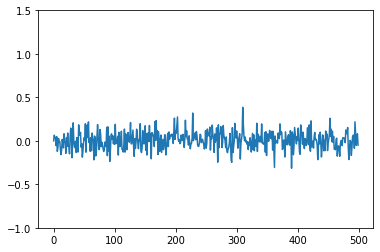

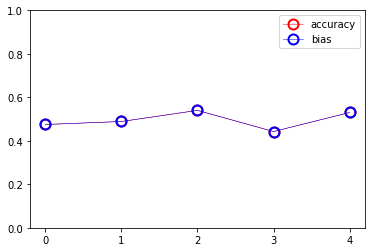

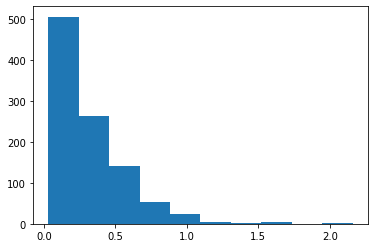

In [10]:
v, df = do_sim()
accbiasplot(df)
plt.figure()
plt.hist(df['rt'])

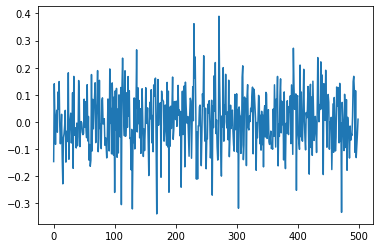

In [143]:
df
plt.plot(v[2])

In [152]:
df.mean()

rt             0.3224
response       0.5260
stimulus       1.0000
correct        0.5260
rt quantile    1.9840
dtype: float64

In [153]:
'''df1.append(df2)''' 

'df1.append(df2)'